In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/future-sales-preprocessing-and-engineering-v1/X_test.parquet
/kaggle/input/future-sales-preprocessing-and-engineering-v1/y_train.parquet
/kaggle/input/future-sales-preprocessing-and-engineering-v1/__results__.html
/kaggle/input/future-sales-preprocessing-and-engineering-v1/X_train.parquet
/kaggle/input/future-sales-preprocessing-and-engineering-v1/date_block_num.parquet
/kaggle/input/future-sales-preprocessing-and-engineering-v1/item_categories.csv
/kaggle/input/future-sales-preprocessing-and-engineering-v1/shops.csv
/kaggle/input/future-sales-preprocessing-and-engineering-v1/__notebook__.ipynb
/kaggle/input/future-sales-preprocessing-and-engineering-v1/__output__.json
/kaggle/input/future-sales-preprocessing-and-engineering-v1/custom.css
/kaggle/input/competitive-data-science-predict-future-sales/items.csv
/kaggle/input/competitive-data-science-predict-future-sales/sample_submission.csv
/kaggle/input/competitive-data-science-predict-future-sales/item_categories.csv
/kagg

In [2]:
DATA_PATH = '/kaggle/input/future-sales-preprocessing-and-engineering-v1/'

y_train = np.clip(pd.read_parquet(DATA_PATH+'y_train.parquet')['item_cnt_month'], 0, 20)
X_train = pd.read_parquet(DATA_PATH+'X_train.parquet')
month_idx = pd.read_parquet(DATA_PATH+'date_block_num.parquet')['date_block_num'].values

In [3]:
def get_cv_folds(n_folds):
    n_folds = min(n_folds, 22)
    for i in range(33, 33-n_folds, -1):
        yield np.nonzero(month_idx < i)[0], np.nonzero(month_idx == i)[0]
        
idxs = np.cumsum(np.unique(month_idx, return_counts=True)[1])

def get_cv_slices(n_folds):
    n_folds = min(n_folds, 22)
    start = len(idxs) - 1
    for i in range(start, start-n_folds, -1):
        yield slice(0, idxs[i-1]), slice(idxs[i-1], idxs[i])

In [4]:
# cast to float16 to reduce RAM consuming
float_cols = [c for c in X_train if X_train[c].dtype == "float32"]

X_train[float_cols] = X_train[float_cols].astype(np.float16, copy=False)

In [5]:
X_train

,shop_id,item_id,item_category_id,primary_category_id,city_id,lag_1_target_sum,lag_2_target_sum,lag_3_target_sum,lag_12_target_sum,lag_1_item_price_mean,...,lag_2_shop_cat_sales_mean,lag_3_shop_cat_sales_mean,lag_12_shop_cat_sales_mean,lag_1_shop_primarycat_sales_mean,lag_2_shop_primarycat_sales_mean,lag_3_shop_primarycat_sales_mean,lag_12_shop_primarycat_sales_mean,month_num,time_from_last_shop_item_sale,time_from_last_item_sale
0,2,27,19,5,1,0.0,0.0,0.0,0.0,1048.00,...,2.373047,2.617188,1.900391,2.947266,2.341797,2.566406,1.777344,0,12,1
1,42,18824,40,10,19,0.0,0.0,0.0,0.0,0.00,...,2.197266,2.332031,1.983398,2.222656,2.091797,2.134766,1.833984,0,231,1
2,42,18825,40,10,19,0.0,0.0,0.0,0.0,0.00,...,2.197266,2.332031,1.983398,2.222656,2.091797,2.134766,1.833984,0,2,1
3,6,2628,55,12,5,0.0,0.0,0.0,0.0,0.00,...,1.486328,1.459961,1.289062,1.454102,1.381836,1.358398,1.237305,0,9,1
4,42,18826,40,10,19,0.0,0.0,0.0,0.0,320.25,...,2.197266,2.332031,1.983398,2.222656,2.091797,2.134766,1.833984,0,5,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6424941,26,13217,47,11,13,0.0,0.0,0.0,0.0,0.00,...,0.000000,0.000000,0.000000,1.593750,1.657227,1.833008,1.286133,9,2,1
6424942,26,13240,47,11,13,0.0,0.0,0.0,0.0,0.00,...,0.000000,0.000000,0.000000,1.593750,1.657227,1.833008,1.286133,9,3,1
6424943,26,13252,47,11,13,0.0,0.0,0.0,0.0,0.00,...,0.000000,0.000000,0.000000,1.593750,1.657227,1.833008,1.286133,9,3,1
6424944,58,564,78,14,28,0.0,0.0,0.0,0.0,0.00,...,0.000000,0.000000,0.000000,2.181641,2.000000,1.857422,2.095703,9,231,1


In [6]:
X_train.columns

Index(['shop_id', 'item_id', 'item_category_id', 'primary_category_id',
       'city_id', 'lag_1_target_sum', 'lag_2_target_sum', 'lag_3_target_sum',
       'lag_12_target_sum', 'lag_1_item_price_mean', 'lag_1_item_price_max',
       'lag_1_item_price_min', 'lag_1_item_price_median',
       'lag_2_item_price_mean', 'lag_2_item_price_max', 'lag_2_item_price_min',
       'lag_2_item_price_median', 'lag_3_item_price_mean',
       'lag_3_item_price_max', 'lag_3_item_price_min',
       'lag_3_item_price_median', 'lag_12_item_price_mean',
       'lag_12_item_price_max', 'lag_12_item_price_min',
       'lag_12_item_price_median', 'lag_1_item_sales_mean',
       'lag_2_item_sales_mean', 'lag_3_item_sales_mean',
       'lag_12_item_sales_mean', 'lag_1_shop_sales_mean',
       'lag_2_shop_sales_mean', 'lag_3_shop_sales_mean',
       'lag_12_shop_sales_mean', 'lag_1_city_sales_mean',
       'lag_2_city_sales_mean', 'lag_3_city_sales_mean',
       'lag_12_city_sales_mean', 'lag_1_cat_sales_mean',


## lightgbm test

In [7]:
import lightgbm as lgbm

In [8]:
tr, vl = list(get_cv_slices(1))[0]
X_val = X_train[vl]
y_val = y_train[vl]
X_train = X_train[tr]
y_train = y_train[tr]

In [9]:
dtrain = lgbm.Dataset(X_train, y_train)
dval = lgbm.Dataset(X_val, y_val)

In [10]:
lgbm_params = {
    'learning_rate': 0.075,
    'objective': 'regression',
    'metric': 'rmse',
    'device_type': 'gpu',
    'verbose': 1,
    'min_data_in_leaf': 2200,
    'min_gain_to_split': 0.5,
    'num_leaves': 33,
    'lambda_l2': 10,
    'bagging_freq': 20,
    'bagging_fraction': 0.85
}

In [11]:
%%time
model = lgbm.train(
    lgbm_params,
    dtrain,
    num_boost_round=362,
    valid_sets=[dtrain, dval],
    valid_names=['train', 'val'],
    early_stopping_rounds=20,
    verbose_eval=10
)

[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 11642
[LightGBM] [Info] Number of data points in the train set: 6186774, number of used features: 56
[LightGBM] [Info] Using GPU Device: Tesla P100-PCIE-16GB, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 31 dense feature groups (188.81 MB) transferred to GPU in 0.251677 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score 0.288855
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 31 dense feature groups (160.53 MB) transferred to GPU in 0.246074 secs. 1 sparse feature groups
Training until validation scores don't improve for 20 rounds
[10]	train's rmse: 1.03448	val's rmse: 1.01982
[20]	train's rmse: 0.987218	val's rmse: 0.98685
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 31 dense feature groups (160.48

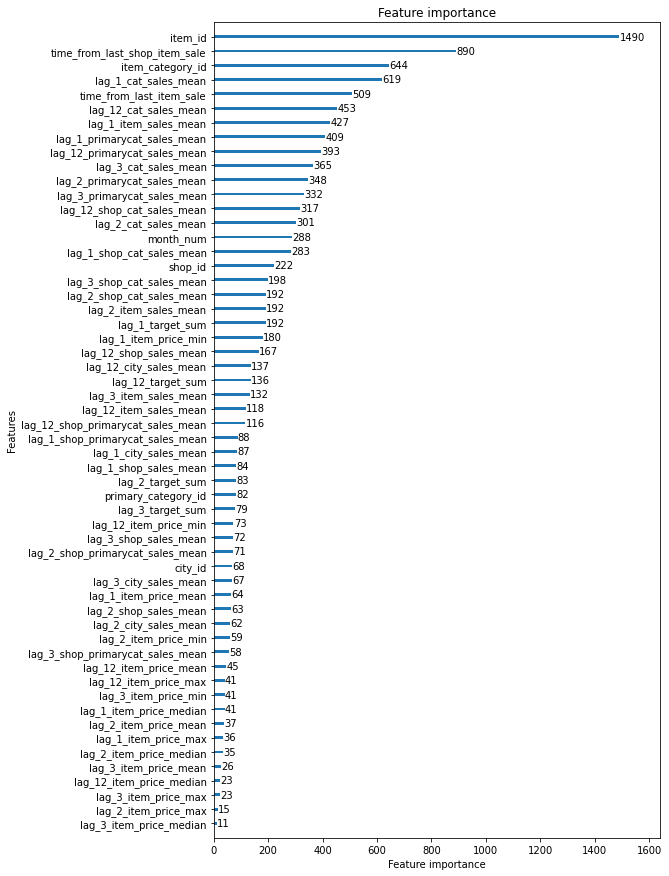

In [18]:
lgbm.plot_importance(model, figsize=(8, 15), grid=False, ignore_zero=False);

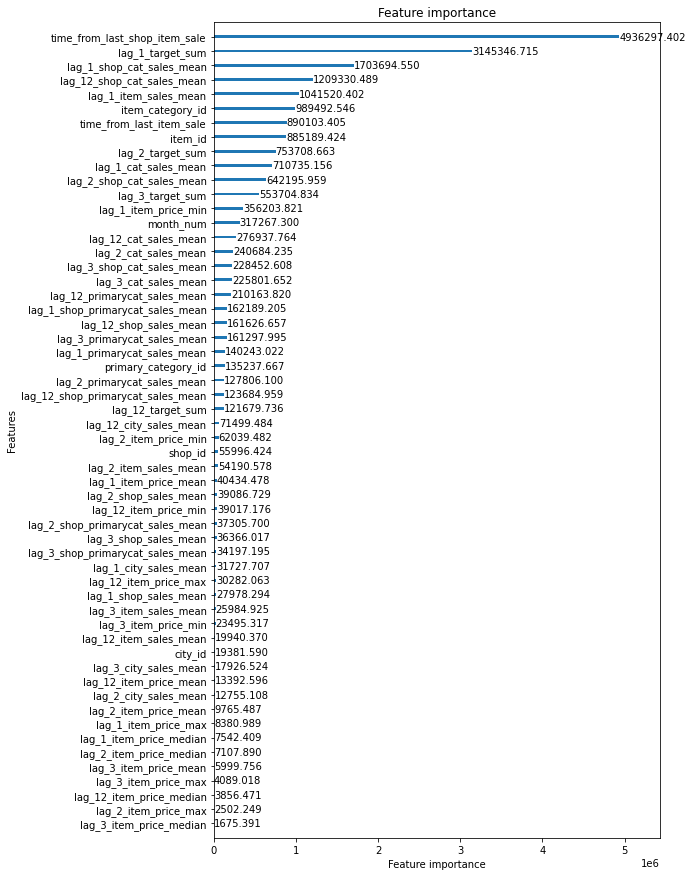

In [19]:
lgbm.plot_importance(model, importance_type='gain', figsize=(8, 15), grid=False, ignore_zero=False);

In [13]:
X_test = pd.read_parquet(DATA_PATH+'X_test.parquet')
y_pred = model.predict(X_test)

subm = pd.DataFrame({'ID': X_test.index, 'item_cnt_month': y_pred}).sort_values('ID')
subm.to_csv('submission.csv', index=False) # LB: 0.987606 and 0.976587